In [8]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import cv2
import math
from PIL import Image, ImageDraw
import platform

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Python version: 3.9.12
Tensorflow version: 2.8.0
Keras version: 2.8.0


In [9]:
PADDING = 0
OUTPUT_SCALE = 1
ERROR_THRESHOLD = 5

def weighted_average(hist):
    """Returns the weighted color average and error from a hisogram of pixles"""
    total = sum(hist)
    value, error = 0, 0
    if total > 0:
        value = sum(i * x for i, x in enumerate(hist)) / total
        error = sum(x * (value - i) ** 2 for i, x in enumerate(hist)) / total
        error = error ** 0.5
    return value, error

def color_from_histogram(hist):
    """Returns the average rgb color from a given histogram of pixle color counts"""
    r, re = weighted_average(hist[:256])
    g, ge = weighted_average(hist[256:512])
    b, be = weighted_average(hist[512:768])
    e = re * 0.2989 + ge * 0.5870 + be * 0.1140
    return (int(r), int(g), int(b)), e

class QuadtreeNode(object):
    """Node for Quadtree that holds a subsection of an image and 
        information about that section"""

    def __init__(self, img, box, depth):
        self.box = box  # (left, top, right, bottom)
        self.depth = depth
        self.children = None  # tl, tr, bl, br
        self.leaf = False

        # Gets the nodes average color
        image = img.crop(box)
        self.width, self.height = image.size  # (width, height)
        hist = image.histogram()
        self.color, self.error = color_from_histogram(hist)  # (r, g, b), error
        
    def is_leaf(self):
            """Determins if a the node is a leaf"""
            return self.leaf
        
    def split(self, img):
        """Splits the given image section into four equal image boxes"""
        l, t, r, b = self.box
        lr = l + (r - l) / 2
        tb = t + (b - t) / 2
        tl = QuadtreeNode(img, (l, t, lr, tb), self.depth+1)
        tr = QuadtreeNode(img, (lr, t, r, tb), self.depth+1)
        bl = QuadtreeNode(img, (l, tb, lr, b), self.depth+1)
        br = QuadtreeNode(img, (lr, tb, r, b), self.depth+1)
        self.children = [tl, tr, bl, br]

class Quadtree(object):
    """Tree that has nodes with at most four child nodes that hold 
        sections of an image where there at most n leaf nodes where
        n is the number of pixles in the image"""

    def __init__(self, image, max_depth=1024):
        self.root = QuadtreeNode(image, image.getbbox(), 0)
        self.width, self.height = image.size
        self.max_depth = 0
        
        self._build_tree(image, self.root, max_depth)

    def _build_tree(self, image, node, max_depth):
        """Recursively adds nodes untill max_depth is reached or error is less than 5"""
        if (node.depth >= max_depth) or (node.error <= ERROR_THRESHOLD):
            if node.depth > self.max_depth:
                self.max_depth = node.depth
            node.leaf = True
            return
        
        node.split(image)
        for child in node.children:
            self._build_tree(image, child, max_depth)
        
    
    def get_leaf_nodes(self, depth):
        """Gets all the nodes on a given depth/level"""
        def get_leaf_nodes_recusion(tree, node, depth, func):
            """Recusivley gets leaf nodes based on whether a node is a leaf or the given depth is reached"""
            if node.leaf is True or node.depth == depth:
                func(node)
            elif node.children is not None:
                for child in node.children:
                    get_leaf_nodes_recusion(tree, child, depth, func)

            if depth > tree.max_depth:
                raise ValueError('A depth larger than the trees depth was given')

        leaf_nodes = []
        get_leaf_nodes_recusion(self, self.root, depth, leaf_nodes.append)
        return leaf_nodes
        

    def _create_image_from_depth(self, depth):
        """Creates a Pillow image object from a given level/depth of the tree"""
        m = OUTPUT_SCALE
        dx, dy = (PADDING, PADDING) # padding for each image section
        image = Image.new('RGB', (int(self.width * m + dx), int(self.height * m + dy)))
        draw = ImageDraw.Draw(image)
        draw.rectangle((0, 0, self.width * m + dx, self.height * m + dy), (0, 0, 0))
        granules = []
        leaf_nodes = self.get_leaf_nodes(depth)
        for node in leaf_nodes:
            l, t, r, b = node.box
            box = (l * m + dx, t * m + dy, r * m - 1, b * m - 1)
            granule_size = (int((r-l) * m), int((b-t) * m))  # Calculate the size of the granule
            granule = Image.new('RGB', granule_size, node.color)  # Create a new image with the size and color of the granule
            granule = np.array(granule)
            granules.append(granule)
            draw.rectangle(box, node.color)
        return image, granules

    def render_at_depth(self, depth=0):
        """Renders the image of a given depth/level"""
        if depth > self.max_depth:
            raise ValueError('A depth larger than the trees depth was given')

        image, granules = self._create_image_from_depth(depth)
        return image, granules
        # image.show()

    def create_gif(self, file_name, duration=1000, loop=0):
        """Creates a gif at the given filename from each level of the tree"""
        images = []
        end_product_image = self._create_image_from_depth(self.max_depth)
        for i in range(self.max_depth):
            image = self._create_image_from_depth(i)
            images.append(image)
        # Add extra final produc images to allow for seeing result longer
        for _ in range(4):
            images.append(end_product_image)
        # Save the images as a gif using Pillow
        images[0].save(
            file_name, 
            save_all=True, 
            append_images=images[1:],
            duration=duration, loop=loop)

In [10]:
def plot(images, titles, subtitle=None, figsize=(8, 8)):
        
    cols = len(images)
    fig, axs = plt.subplots(1, cols, figsize=(cols * figsize[0], figsize[1]))
    if len(images) == 1:
        axs = [axs]
    if subtitle is not None:
        fig.suptitle(subtitle, fontsize=16)
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axs[i]
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.show()

In [11]:
def granulation_gt(frame, visual=False):
    frame_pil = Image.fromarray(frame)
    tree = Quadtree(frame_pil)
    image = tree.render_at_depth(6)
    image, granules = np.array(image)
    if visual:
        plot([frame, image], ['Original', 'Granulated'], subtitle='Granulation')
    return image, granules

/var/folders/z8/z_bh56_j7cxf4jpbcjf1hbmh0000gn/T/ipykernel_32522/3579238169.py:5: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  image, granules = np.array(image)
/var/folders/z8/z_bh56_j7cxf4jpbcjf1hbmh0000gn/T/ipykernel_32522/3579238169.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image, granules = np.array(image)


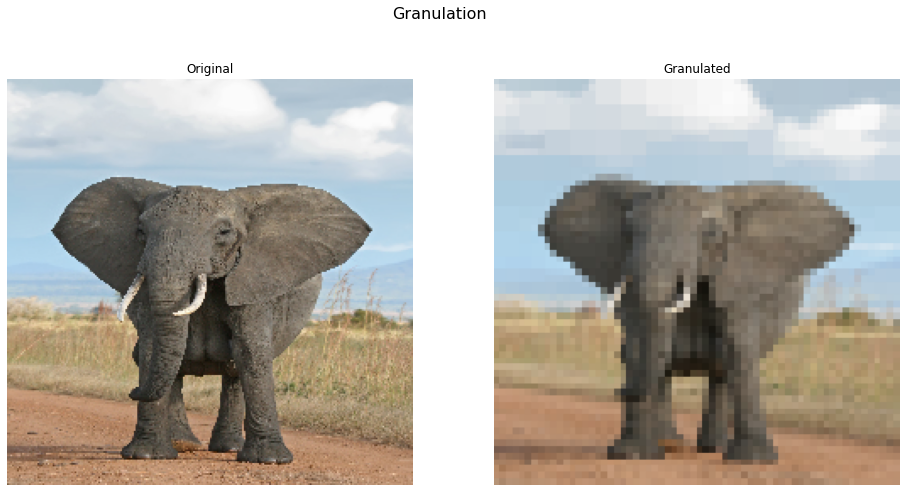

In [12]:
img = cv2.cvtColor(cv2.imread('data/elephant.jpg'), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (240, 240))
_, granules = granulation_gt(img, visual=True)

In [13]:
WINDOW_SIZE = 10

def compute_threshold_qtd(image, qtd_granules):
    R_OT_best = 1
    R_BT_best = 1
    T_best = 0
    print( np.mean(image), np.std(image))
    t_start = max(int(np.mean(image) - np.std(image)), 0)
    t_end = min(int(np.mean(image) + np.std(image)), 255)
    for T in range(t_start, t_end, 5):
        O_T_lower = []
        O_T_upper = []
        B_T_lower = []
        B_T_upper = []
        for granule in qtd_granules:
            granule_greater_T = granule > T
            granule_less_T = granule < T
            if len(granule_greater_T) > 1:
                if np.all(granule_greater_T):
                    O_T_lower.append(granule)
                if np.any(granule_greater_T):
                    O_T_upper.append(granule)
            if len(granule_less_T):
                if np.all(granule_less_T):
                    B_T_lower.append(granule)
                if np.any(granule_less_T):
                    B_T_upper.append(granule)
        R_OT = 1 - len(O_T_lower) / len(O_T_upper) if len(O_T_upper) != 0 else 1
        R_BT = 1 - len(B_T_lower) / len(B_T_upper) if len(B_T_upper) != 0 else 1
        if R_OT + R_BT < R_OT_best +  R_BT_best:
            R_OT_best = R_OT
            R_BT_best = R_BT
            T_best = T
        # print('R_OT:', R_OT, '   R_BT:', R_BT, '   T:', T)
    return R_OT_best, R_BT_best, T_best

In [14]:
print(compute_threshold_qtd(img, granules))

151.90696180555557 59.57019946664796
(0.16534541336353337, 0.45945945945945943, 92)
